In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(10,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l2 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy
    
    def call(self, inputs):
        feat = tf.nn.sigmoid(self.l1(inputs))
        feat = tf.nn.sigmoid(self.l2(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch
    
    def clear(self):
        self.buffer.clear()
        self.count = 0


In [2]:
def learning_step(critic, buffer, optimizer, batch_size=250):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda][-1] 
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))

In [4]:
buffer = ReplayBuffer()
critic = Critic()
n_qubits = 3
solver = PennylaneSolver(n_qubits, combinatorial_only=True)

env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)
optimizer = tf.keras.optimizers.Adam(lr=0.01)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,10**4,1)
tt = .75*len(episodes)/np.log(1/0.05)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.1, np.exp(-k/tt))
    
for k in tqdm(episodes):
    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)
    
    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state
    if (k>10**3):
        learning_step(critic, buffer, optimizer)
    pt.append(reward)

100%|██████████| 9999/9999 [19:40<00:00,  8.47it/s]


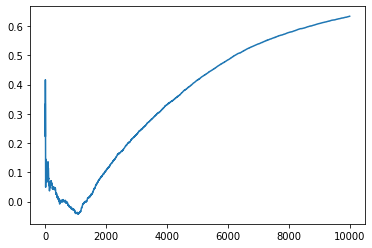

In [5]:
plt.plot(r/episodes)

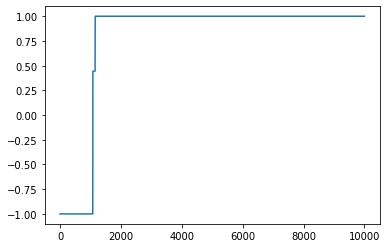

In [6]:
plt.plot(pt)